In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_predict
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, GRU, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.stats import norm
from scipy import stats

/home/gorka/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-06-13 14:03:39.259718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 14:03:39.259746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 14:03:39.260740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been re

# Exploratory data analysis

In [2]:
# Load all files
cities = pd.read_csv("city_attributes.csv")
humidity = pd.read_csv("humidity.csv")
temperature = pd.read_csv("temperature.csv")
pressure = pd.read_csv("pressure.csv")
weather_description = pd.read_csv("weather_description.csv")
wind_direction = pd.read_csv("wind_direction.csv")
wind_speed = pd.read_csv("wind_speed.csv")

In [3]:
# Modify the format of the data for later merging
humidity_melted = humidity.melt(id_vars=['datetime'], var_name='City', value_name='Humidity')
pressure_melted = pressure.melt(id_vars=['datetime'], var_name='City', value_name='Pressure')
temperature_melted = temperature.melt(id_vars=['datetime'], var_name='City', value_name='Temperature')
weather_description_melted = weather_description.melt(id_vars=['datetime'], var_name='City', value_name='Weather_Description')
wind_direction_melted = wind_direction.melt(id_vars=['datetime'], var_name='City', value_name='Wind_Direction')
wind_speed_melted = wind_speed.melt(id_vars=['datetime'], var_name='City', value_name='Wind_Speed')

In [4]:
# Combine all dataframes
combined_df = humidity_melted.merge(pressure_melted, on=['datetime', 'City'])
combined_df = combined_df.merge(temperature_melted, on=['datetime', 'City'])
combined_df = combined_df.merge(weather_description_melted, on=['datetime', 'City'])
combined_df = combined_df.merge(wind_direction_melted, on=['datetime', 'City'])
combined_df = combined_df.merge(wind_speed_melted, on=['datetime', 'City'])

In [5]:
# Change temperature units from Kelvin to Celsius
combined_df["temp_C"] = combined_df["Temperature"] - 273.15

In [6]:
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], format='%Y-%m-%d %H:%M:%S')
combined_df.set_index("datetime")

City  Humidity  Pressure  Temperature  \
datetime                                                          
2012-10-01 12:00:00  Vancouver       NaN       NaN          NaN   
2012-10-01 13:00:00  Vancouver      76.0       NaN   284.630000   
2012-10-01 14:00:00  Vancouver      76.0       NaN   284.629041   
2012-10-01 15:00:00  Vancouver      76.0       NaN   284.626998   
2012-10-01 16:00:00  Vancouver      77.0       NaN   284.624955   
...                        ...       ...       ...          ...   
2017-11-29 20:00:00  Jerusalem       NaN       NaN          NaN   
2017-11-29 21:00:00  Jerusalem       NaN       NaN          NaN   
2017-11-29 22:00:00  Jerusalem       NaN       NaN          NaN   
2017-11-29 23:00:00  Jerusalem       NaN       NaN          NaN   
2017-11-30 00:00:00  Jerusalem       NaN       NaN          NaN   

                    Weather_Description  Wind_Direction  Wind_Speed     temp_C  
datetime                                                                        
2012-10-01 12:00:00                 NaN             NaN         NaN        NaN  
2012-10-01 13:00:00                mist             0.0         0.0  11.480000  
2012-10-01 14:00:00       broken clouds             6.0         0.0  11.479041  
2012-10-01 15:00:00       broken clouds            20.0         0.0  11.476998  
2012-10-01 16:00:00       broken clouds            34.0         0.0  11.474955  
...                                 ...             ...         ...        ...  
2017-11-29 20:00:00                 NaN             NaN         NaN        NaN  
2017-11-29 21:00:00                 NaN             NaN         NaN        NaN  
2017-11-29 22:00:00                 NaN             NaN         NaN        NaN  
2017-11-29 23:00:00                 NaN             NaN         NaN        NaN  
2017-11-30 00:00:00                 NaN             NaN         NaN        NaN  

[1629108 rows x 8 columns]

In [7]:
combined_df.head()

datetime       City  Humidity  Pressure  Temperature  \
0 2012-10-01 12:00:00  Vancouver       NaN       NaN          NaN   
1 2012-10-01 13:00:00  Vancouver      76.0       NaN   284.630000   
2 2012-10-01 14:00:00  Vancouver      76.0       NaN   284.629041   
3 2012-10-01 15:00:00  Vancouver      76.0       NaN   284.626998   
4 2012-10-01 16:00:00  Vancouver      77.0       NaN   284.624955   

  Weather_Description  Wind_Direction  Wind_Speed     temp_C  
0                 NaN             NaN         NaN        NaN  
1                mist             0.0         0.0  11.480000  
2       broken clouds             6.0         0.0  11.479041  
3       broken clouds            20.0         0.0  11.476998  
4       broken clouds            34.0         0.0  11.474955

In [8]:
print("Missing data by column and city:")
null_count = combined_df.isnull().groupby(combined_df['City']).sum()
null_count['total'] = null_count.sum(axis=1)
null_count

Missing data by column and city:


datetime  City  Humidity  Pressure  Temperature  \
City                                                                 
Albuquerque               0     0       710       456            1   
Atlanta                   0     0       422        49            6   
Beersheba                 0     0       859       806          798   
Boston                    0     0       449         7            3   
Charlotte                 0     0       589         3            3   
Chicago                   0     0      1109       725            3   
Dallas                    0     0       319        60            4   
Denver                    0     0      1808       543            1   
Detroit                   0     0       862         5            1   
Eilat                     0     0       970       792          792   
Haifa                     0     0       818       798          798   
Houston                   0     0       121         9            3   
Indianapolis              0     0       695       289            7   
Jacksonville              0     0       209        15            1   
Jerusalem                 0     0       906       799          793   
Kansas City               0     0       512       121            1   
Las Vegas                 0     0       842        88            1   
Los Angeles               0     0       152       252            3   
Miami                     0     0      1087       794          805   
Minneapolis               0     0       510        17           13   
Montreal                  0     0      1696       994            3   
Nahariyya                 0     0       817       795          797   
Nashville                 0     0       567       147            2   
New York                  0     0      1624      1041          793   
Philadelphia              0     0       624         4            3   
Phoenix                   0     0      1308       594            3   
Pittsburgh                0     0       522        46            3   
Portland                  0     0       449         4            1   
Saint Louis               0     0      1289        68            1   
San Antonio               0     0       564        17            1   
San Diego                 0     0       344       175            1   
San Francisco             0     0       942       815          793   
Seattle                   0     0       289        13            3   
Tel Aviv District         0     0      1113       930          793   
Toronto                   0     0       728       175            1   
Vancouver                 0     0      1826      4234          795   

                   Weather_Description  Wind_Direction  Wind_Speed  temp_C  \
City                                                                         
Albuquerque                          1               1           4       1   
Atlanta                              1               1           1       6   
Beersheba                          793             793         793     798   
Boston                               1               1           1       3   
Charlotte                            1               1           2       3   
Chicago                              1               1           1       3   
Dallas                               1               1           2       4   
Denver                               1               1           2       1   
Detroit                              1               1           1       1   
Eilat                              792             797         792     792   
Haifa                              793             793         795     798   
Houston                              1               2           3       3   
Indianapolis                         1               1           1       7   
Jacksonville                         1               5           1       1   
Jerusalem                          793             793         794     793   
Kansas City                     

From now on we will work just with data from Dallas (for not reason in particular).

In [9]:
dallas = combined_df[combined_df["City"]=="Dallas"]

In [10]:
# Upsampling by backwards filling to work around missing values
dallas=dallas.bfill()
dallas.isnull().sum()

datetime               0
City                   0
Humidity               0
Pressure               0
Temperature            0
Weather_Description    0
Wind_Direction         0
Wind_Speed             0
temp_C                 0
dtype: int64

In [11]:
print("Information about the data:")
dallas.info()

Information about the data:
<class 'pandas.core.frame.DataFrame'>
Index: 45253 entries, 497783 to 543035
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             45253 non-null  datetime64[ns]
 1   City                 45253 non-null  object        
 2   Humidity             45253 non-null  float64       
 3   Pressure             45253 non-null  float64       
 4   Temperature          45253 non-null  float64       
 5   Weather_Description  45253 non-null  object        
 6   Wind_Direction       45253 non-null  float64       
 7   Wind_Speed           45253 non-null  float64       
 8   temp_C               45253 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 3.5+ MB


In [12]:
print("Summary statistics of the data:")
dallas.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Summary statistics of the data:


datetime     Humidity     Pressure  Temperature Wind_Direction  \
count  45253.00000  45253.00000  45253.00000  45253.00000    45253.00000   
mean           .5f     64.26756   1018.89861    292.37568      166.07655   
min            .5f      9.00000    979.00000    261.61033        0.00000   
25%            .5f     50.00000   1013.00000    285.72000      110.00000   
50%            .5f     65.00000   1017.00000    293.56300      167.00000   
75%            .5f     79.00000   1025.00000    299.55000      201.00000   
max            .5f    100.00000   1071.00000    314.40000      360.00000   
std            nan     19.60680      9.02920      9.46443       91.41640   

        Wind_Speed       temp_C  
count  45253.00000  45253.00000  
mean       3.63191     19.22568  
min        0.00000    -11.53967  
25%        2.00000     12.57000  
50%        3.00000     20.41300  
75%        5.00000     26.40000  
max       50.00000     41.25000  
std        2.20791      9.46443

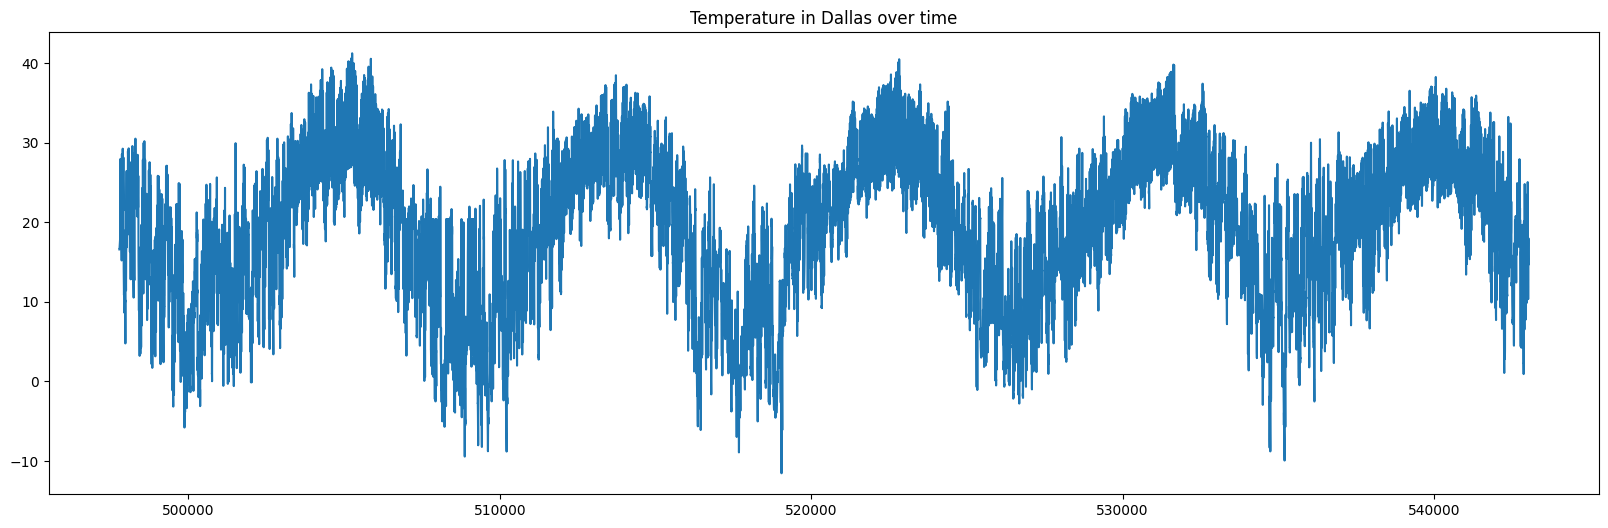

In [13]:
plt.figure(figsize=(20, 6))
dallas['temp_C'].plot() 
plt.title('Temperature in Dallas over time')
plt.show()

In [14]:
# Same plot as above but using plotly library
fig = go.Figure([go.Scatter(x=dallas['datetime'], y=dallas['temp_C'])])
fig.update_layout(
    title={
        'text': "Temperature in Dallas over time",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Date",
    yaxis_title="Temp (°C)"
)
fig.show()

/usr/lib/python3/dist-packages/_plotly_utils/basevalidators.py:107: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [15]:
# Comparing all the different years
fig = go.Figure()
for year in [2012,2013,2014,2015,2016,2017]:
     fig.add_trace(go.Scatter(x=np.arange(1, 366*24), y=dallas[(dallas["datetime"].dt.year==year)]['temp_C'],mode='lines', name=str(year)))
fig.update_layout(
    title={
        'text': "Comparisson of temperature in Dallas",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Date",
    yaxis_title="Temp (°C)"
)
fig.show()

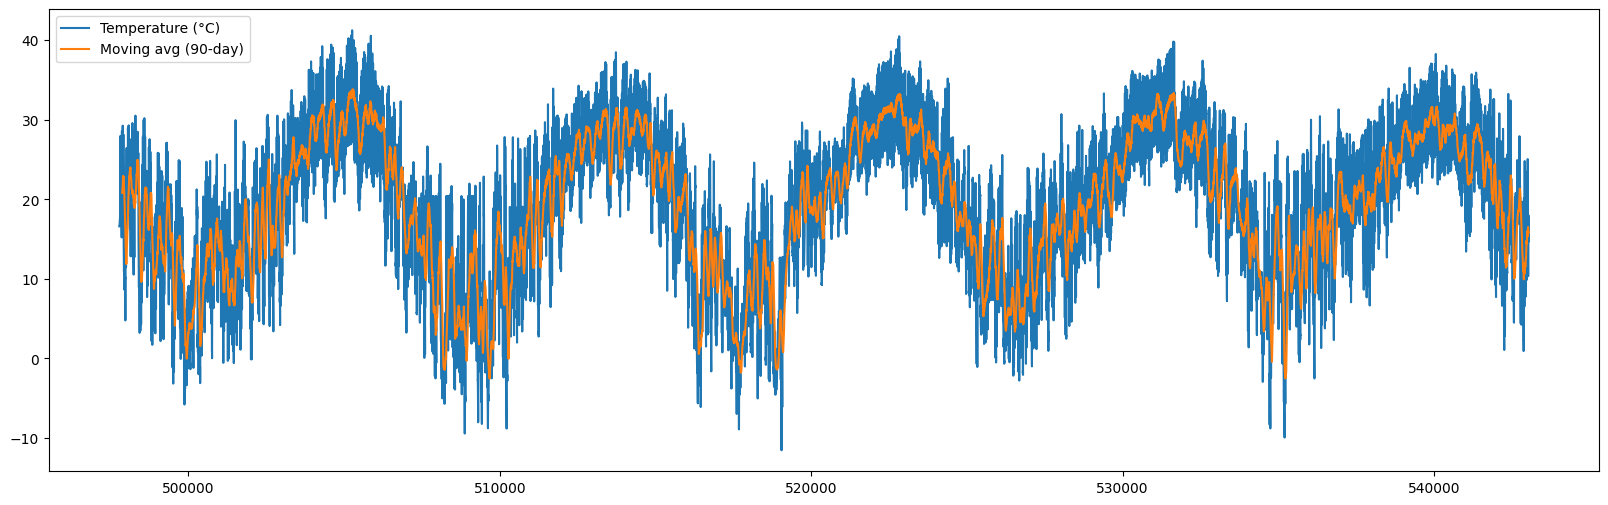

In [16]:
plt.figure(figsize=(20, 6))
dallas['temp_C'].plot()
dallas["temp_C"].rolling(90).mean().plot()
plt.legend(['Temperature (°C)','Moving avg (90-day)'])
plt.show()

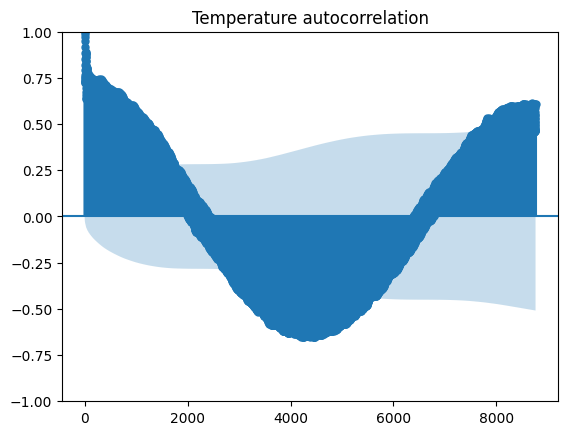

In [17]:
# Autocorrelation of temperature
plot_acf(dallas["temp_C"],lags=24*365,title="Temperature autocorrelation")
plt.show()

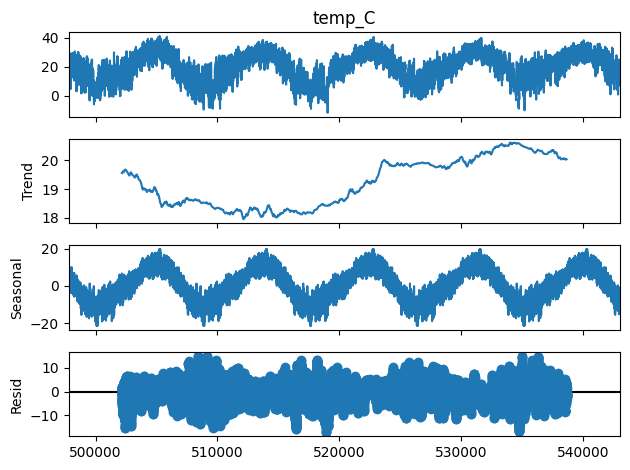

In [18]:
sm.tsa.seasonal_decompose(dallas["temp_C"], period=24*365).plot()
plt.show()

# Modelling

In [19]:
# Remove temperature outliers
outliers = (np.abs(stats.zscore(dallas["temp_C"]))>2.576)
filtered_data = dallas[~outliers]

In [20]:
# Get one hot encoding variables for weather description
df = filtered_data.copy()
df = pd.get_dummies(df, columns=['Weather_Description'], drop_first=True)

In [21]:
# Add day of the year column
df["day"] = df["datetime"].dt.day_of_year
df["hour"] = df["datetime"].dt.hour

In [22]:
# Splitting the data for the model training and testing
N = len(df)
split = 0.9
training_size = round(split*N)
test_size = round((1-split)*N)
train_df = df[:training_size].set_index("datetime")
test_df = df[len(train_df)-1:len(df)].set_index("datetime")

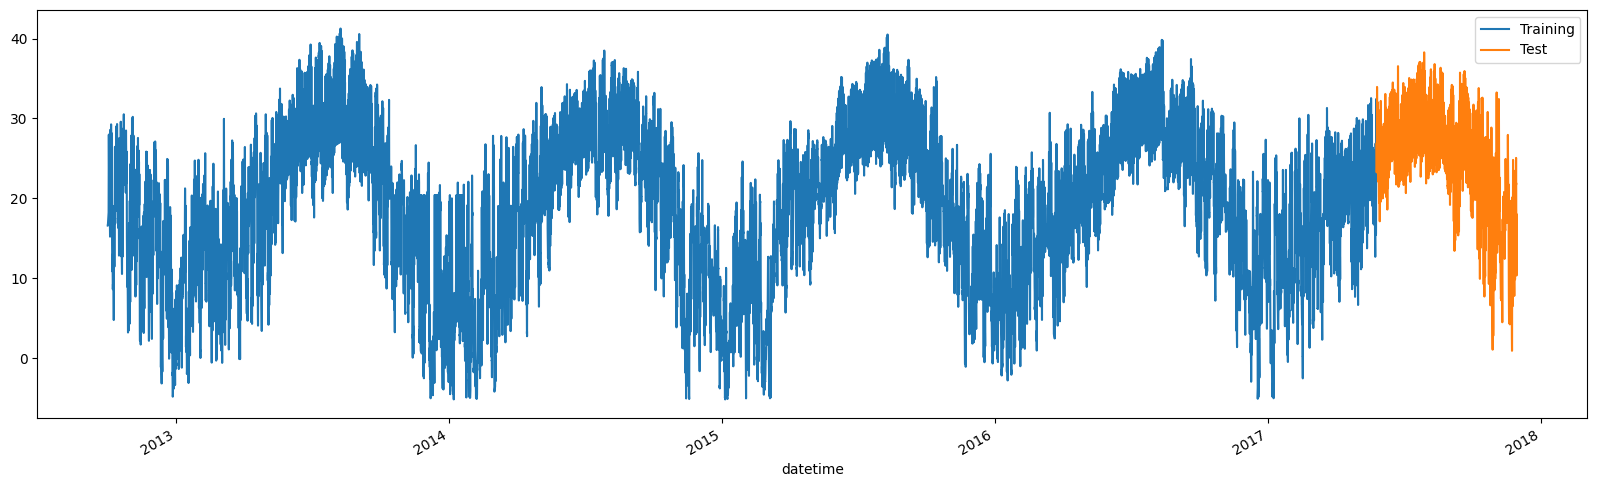

In [23]:
plt.figure(figsize=(20,6))
train_df["temp_C"].plot()
test_df["temp_C"].plot()
plt.legend(['Training','Test'])
plt.show()

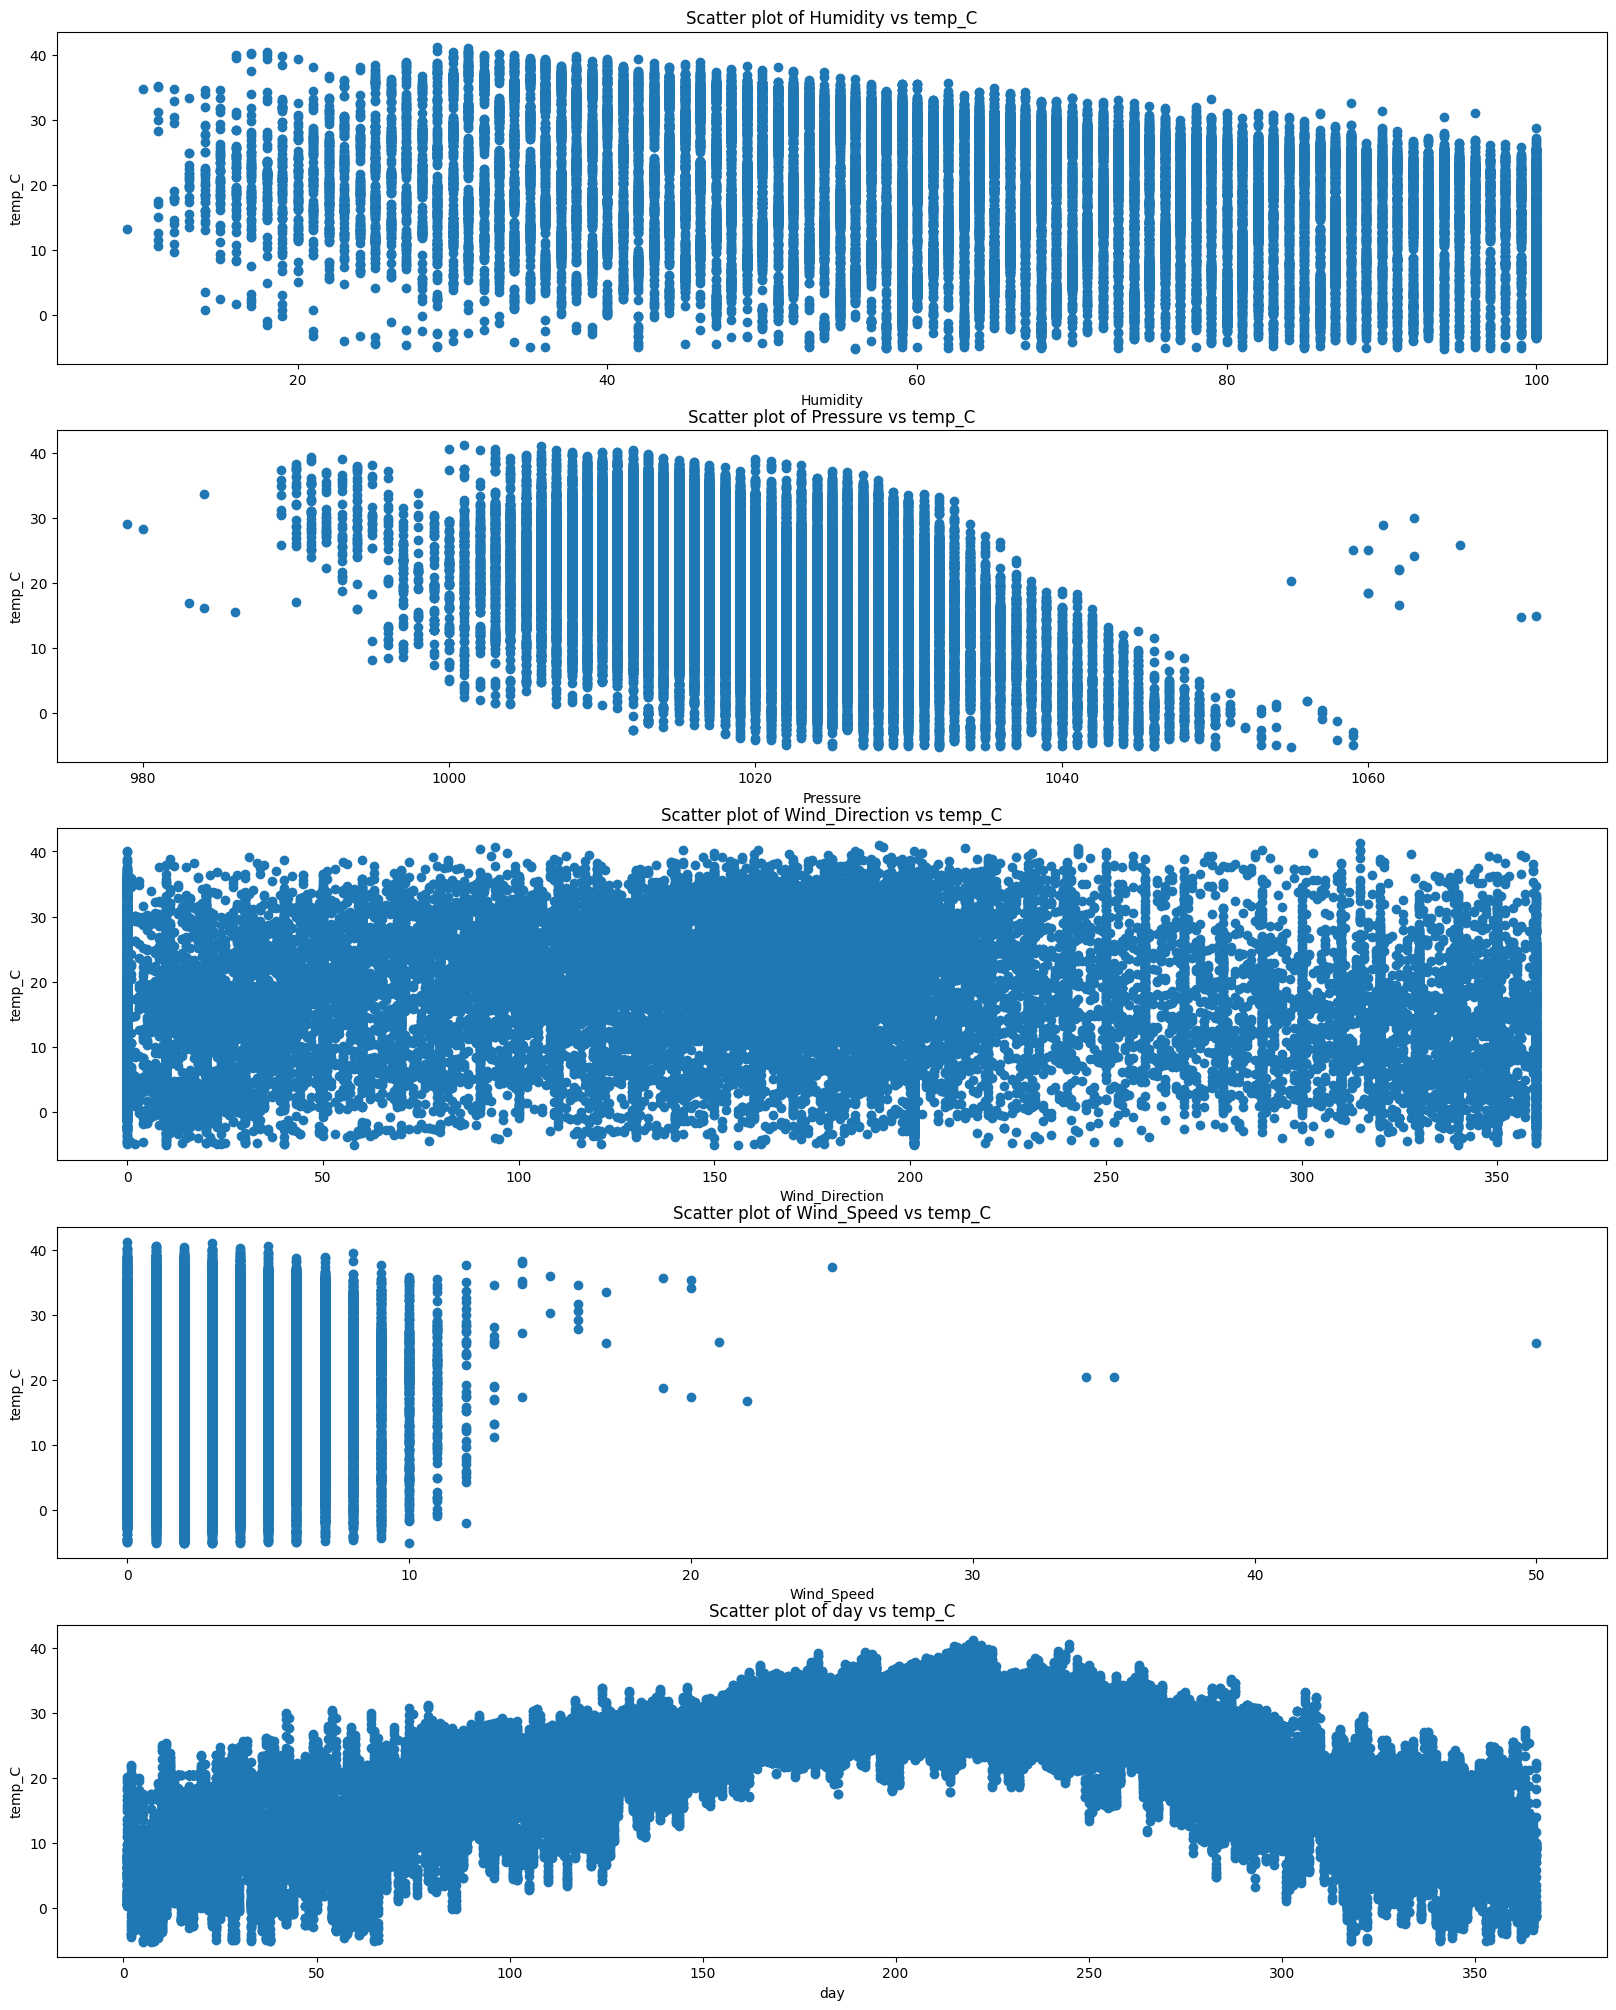

In [24]:
#Plotting the relations between explanatory and response variables
cols = ['Humidity', 'Pressure', 'Wind_Direction', 'Wind_Speed', "day"]

fig, ax = plt.subplots(5,1, figsize=(20,25))
for i, var in enumerate(cols):
    ax[i].scatter(df[var], df["temp_C"])
    ax[i].set_xlabel(var)
    ax[i].set_ylabel("temp_C")
    ax[i].set_title(f'Scatter plot of {var} vs temp_C')
plt.show()

In [25]:
# Standarize numerical variables for Neural Network
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train = scaler_X.fit_transform(train_df.drop(columns=["temp_C", "Temperature", "City"]).values.astype('float32'))
Y_train = scaler_Y.fit_transform(train_df["temp_C"].values.astype('float32').reshape(-1,1))
X_test = scaler_X.transform(test_df.drop(columns=["temp_C", "Temperature", "City"]).values.astype('float32'))
Y_test = scaler_Y.transform(test_df["temp_C"].values.astype('float32').reshape(-1,1))

In [26]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [31]:
tf.keras.backend.clear_session()
# The LSTM architecture
regressor = Sequential()
regressor.add(Input(shape=(X_train.shape[1],1)))

regressor.add(LSTM(units=50, return_sequences=True, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')

In [32]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 37, 50)            10400     
                                                                 
 batch_normalization (Batch  (None, 37, 50)            200       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 37, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 37, 50)            20200     
                                                                 
 batch_normalization_1 (Bat  (None, 37, 50)            200       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 37, 50)            0

Epoch 1/50
812/812 [==============================] - 9s 8ms/step - loss: 0.6504 - val_loss: 0.1807
Epoch 2/50
812/812 [==============================] - 6s 7ms/step - loss: 0.3059 - val_loss: 0.4116
Epoch 3/50
812/812 [==============================] - 6s 7ms/step - loss: 0.2528 - val_loss: 0.1464
Epoch 4/50
812/812 [==============================] - 6s 7ms/step - loss: 0.2311 - val_loss: 0.1670
Epoch 5/50
812/812 [==============================] - 6s 7ms/step - loss: 0.2086 - val_loss: 0.1011
Epoch 6/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1934 - val_loss: 0.1183
Epoch 7/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1787 - val_loss: 0.1505
Epoch 8/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1725 - val_loss: 0.0992
Epoch 9/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1671 - val_loss: 0.1193
Epoch 10/50
812/812 [==============================] - 6s 7ms/step - loss: 0.1642 - val_loss: 0.1283

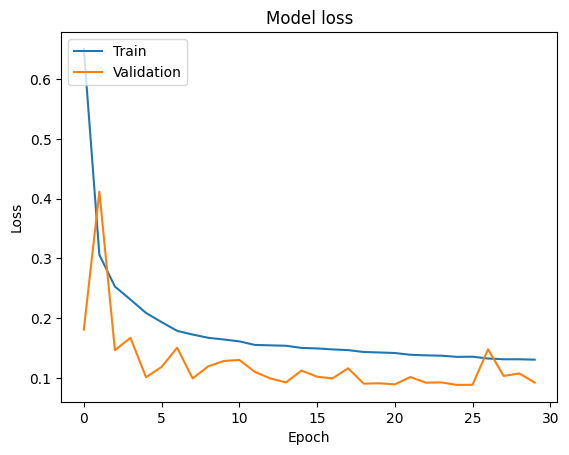

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fitting to the training set
history = regressor.fit(X_train, Y_train, epochs=50, batch_size=50, callbacks=[early_stopping], validation_data=(X_test, Y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

In [34]:
predictions = regressor.predict(X_test)
pred_inv = scaler_Y.inverse_transform(predictions)

predictions_train = regressor.predict(X_train)
pred_train_inv = scaler_Y.inverse_transform(predictions_train)

Y_test_inv = scaler_Y.inverse_transform(Y_test)
Y_train_inv = scaler_Y.inverse_transform(Y_train)

1268/1268 [==============================] - 3s 2ms/step


<Figure size 2000x600 with 0 Axes>

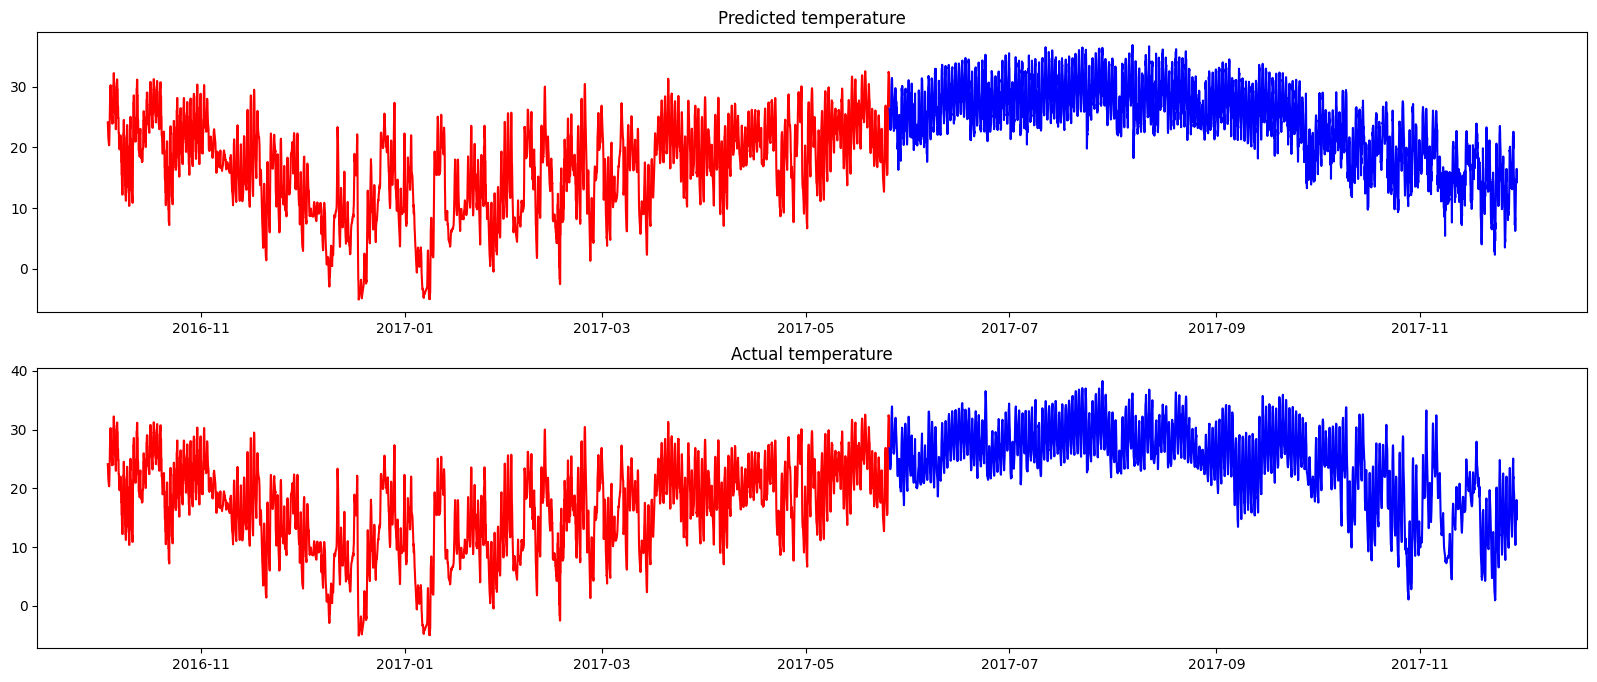

In [35]:
# Predictions
plt.figure(figsize=(20,6))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
ax1.plot(train_df.index[35000:], Y_train_inv[35000:], color="red")
ax1.plot(test_df.index, pred_inv[:,0], color="blue")
ax1.set_title('Predicted temperature')
ax2.plot(train_df.index[35000:], Y_train_inv[35000:], color="red")
ax2.plot(test_df.index, Y_test_inv, color="blue")
ax2.set_title('Actual temperature')
plt.show()

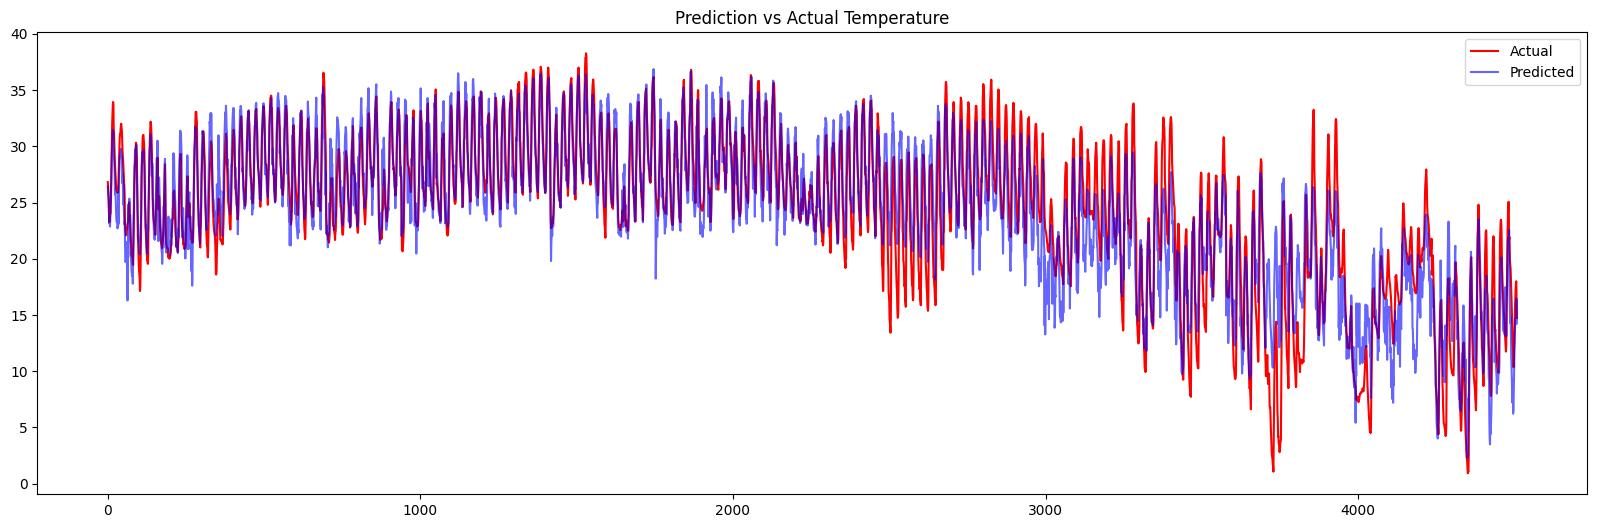

In [36]:
# Actual data
plt.figure(figsize=(20,6))
plt.title("Prediction vs Actual Temperature")
plt.plot(Y_test_inv, color="red", label="Actual")
plt.plot(pred_inv, color="blue", label="Predicted", alpha=0.6)
plt.legend()
plt.show()

In [37]:
# Calculate train MAE
mae_train = mean_absolute_error(Y_train_inv, pred_train_inv)
print(f'Mean Absolute Error (MAE): {mae_train}')

# Calculate train MSE
mse_train = mean_squared_error(Y_train_inv, pred_train_inv)
print(f'Mean Squared Error (MSE): {mse_train}')

# Calculate train RMSE
rmse_train = np.sqrt(mse_train)
print(f'Root Mean Squared Error (RMSE): {rmse_train}')

Mean Absolute Error (MAE): 2.2568836212158203
Mean Squared Error (MSE): 8.915033340454102
Root Mean Squared Error (RMSE): 2.9858052730560303


In [38]:
# Calculate test MAE
mae_test = mean_absolute_error(Y_test_inv, pred_inv)
print(f'Mean Absolute Error (MAE): {mae_test}')

# Calculate test MSE
mse_test = mean_squared_error(Y_test_inv, pred_inv)
print(f'Mean Squared Error (MSE): {mse_test}')

# Calculate test RMSE
rmse_test = np.sqrt(mse_test)
print(f'Root Mean Squared Error (RMSE): {rmse_test}')

Mean Absolute Error (MAE): 2.0730984210968018
Mean Squared Error (MSE): 7.816133499145508
Root Mean Squared Error (RMSE): 2.7957348823547363


In [39]:
# We get the errors of a model consiting of just the mean to compare
print('Mean Absolute Error (MAE): ', mean_absolute_error(Y_test_inv, np.full(len(Y_test_inv), np.mean(Y_test_inv))))
print('Mean Squared Error (MSE): ', mean_squared_error(Y_test_inv, np.full(len(Y_test_inv), np.mean(Y_test_inv))))
print('Root Mean Squared Error (RMSE): ', np.sqrt(mean_squared_error(Y_test_inv, np.full(len(Y_test_inv), np.mean(Y_test_inv)))))

Mean Absolute Error (MAE):  5.2871914
Mean Squared Error (MSE):  46.558987
Root Mean Squared Error (RMSE):  6.823415


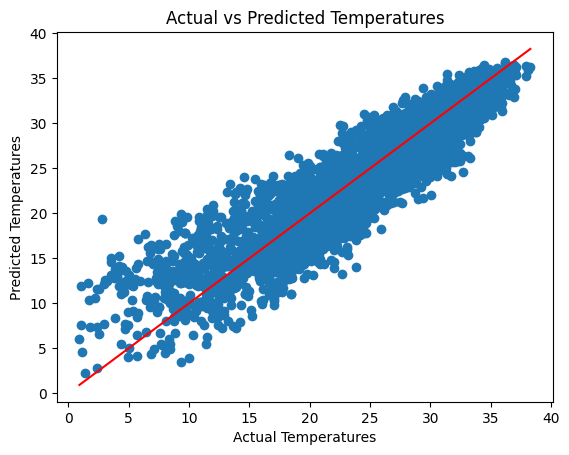

In [40]:
plt.scatter(Y_test_inv, pred_inv)
plt.plot([min(Y_test_inv), max(Y_test_inv)], [min(Y_test_inv), max(Y_test_inv)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Temperatures')
plt.ylabel('Predicted Temperatures')
plt.title('Actual vs Predicted Temperatures')
plt.show()

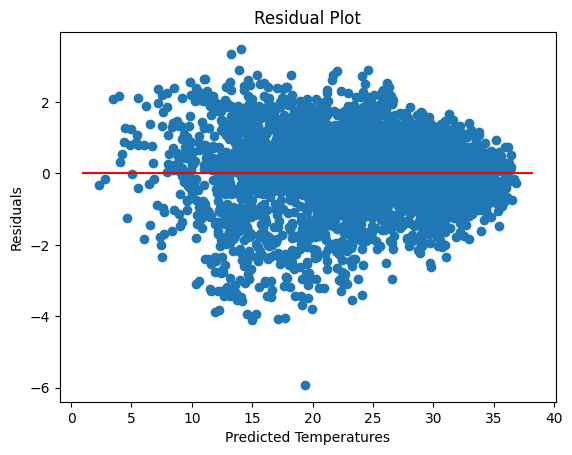

In [41]:
residuals = np.array(Y_test_inv) - np.array(pred_inv)
residuals = residuals/np.std(residuals)
plt.scatter(pred_inv, residuals)
plt.hlines(y=0, xmin=min(Y_test_inv), xmax=max(Y_test_inv), color='red')
plt.xlabel('Predicted Temperatures')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

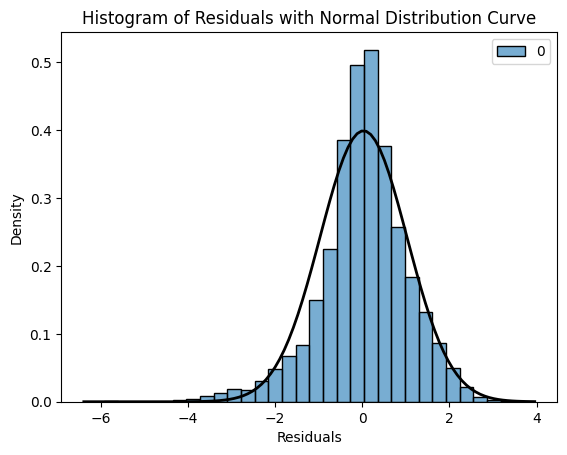

In [42]:
sns.histplot(residuals, kde=False, stat="density", bins=30, color="blue", alpha=0.6)

mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_residuals, std_residuals)

plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Residuals with Normal Distribution Curve')
plt.xlabel('Residuals')
plt.ylabel('Density')

plt.show()

In [58]:
def predict_future(model, initial_sequence, n_steps, scaler):
    predictions = []
    current_sequence = initial_sequence
    
    for _ in range(n_steps):
        # Predict the next time step
        next_step = model.predict(current_sequence[np.newaxis, :, :])
        
        # Store the prediction
        predictions.append(next_step[0])
        
        # Update the sequence to include the new prediction and remove the oldest value
        current_sequence = np.append(current_sequence[1:], next_step, axis=0)
    
    # Inverse transform the predictions to original scale
    predictions = scaler.inverse_transform(predictions)
    
    return predictions

In [61]:
predict = predict_future(regressor, X_test[-1],24*7, scaler_Y)
predict

1/1 [==============================] - 0s 13ms/step


array([[14.27056671],
       [ 3.30419477],
       [ 5.09992072],
       [ 3.87697962],
       [-2.95280909],
       [-2.32905177],
       [-3.60242009],
       [-4.38180653],
       [-5.88764917],
       [-5.6315022 ],
       [-6.32972176],
       [-6.7063883 ],
       [-6.01155919],
       [-6.42887985],
       [-6.51770274],
       [-6.64516254],
       [-6.71128214],
       [-6.99217432],
       [-7.18648745],
       [-7.32142152],
       [-7.33194519],
       [-7.41869028],
       [-7.64868067],
       [-7.71275163],
       [-7.79853636],
       [-7.97135338],
       [-8.17136815],
       [-6.74030637],
       [-6.074865  ],
       [-6.02747484],
       [-6.22171168],
       [-6.8032599 ],
       [-8.69819778],
       [-8.00076356],
       [-6.02821082],
       [-6.4170166 ],
       [-9.21976557],
       [-9.84961944],
       [-9.32914889],
       [-9.36499443],
       [-9.13791656],
       [-8.89338601],
       [-8.83071073],
       [-8.59112114],
       [-8.40949923],
       [-8

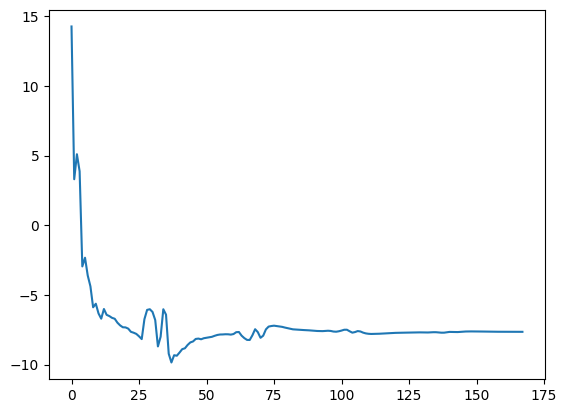

In [62]:
plt.plot(predict)

In [ ]:
data = df[["temp_C", "hour", "day"]]
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_ts = scaler_X.fit_transform(data.drop(columns=["temp_C"]).values.astype('float32'))
Y_ts = scaler_Y.fit_transform(data["temp_C"].values.astype('float32').reshape(-1,1))

In [ ]:
train_size = int(len(X_ts) * 0.8)
X_ts_train, X_ts_test = X_ts[:train_size], X_ts[train_size:]
Y_ts_train, Y_ts_test = Y_ts[:train_size], Y_ts[train_size:]

In [ ]:
tf.keras.backend.clear_session()
# The LSTM architecture
regressor = Sequential()
regressor.add(Input(shape=(X_ts_train.shape[1],1)))

regressor.add(LSTM(units=50, return_sequences=True, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, activation='tanh'))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')

In [ ]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10400     
                                                                 
 batch_normalization (Batch  (None, 2, 50)             200       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 50)             20200     
                                                                 
 batch_normalization_1 (Bat  (None, 2, 50)             200       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 2, 50)             0

Epoch 1/50
722/722 [==============================] - 7s 6ms/step - loss: 0.7025 - val_loss: 0.2533
Epoch 2/50
722/722 [==============================] - 4s 6ms/step - loss: 0.3796 - val_loss: 0.2852
Epoch 3/50
722/722 [==============================] - 4s 5ms/step - loss: 0.3425 - val_loss: 0.2831
Epoch 4/50
722/722 [==============================] - 4s 5ms/step - loss: 0.3304 - val_loss: 0.2697
Epoch 5/50
722/722 [==============================] - 4s 5ms/step - loss: 0.3252 - val_loss: 0.3212
Epoch 6/50
722/722 [==============================] - 4s 5ms/step - loss: 0.3207 - val_loss: 0.3005


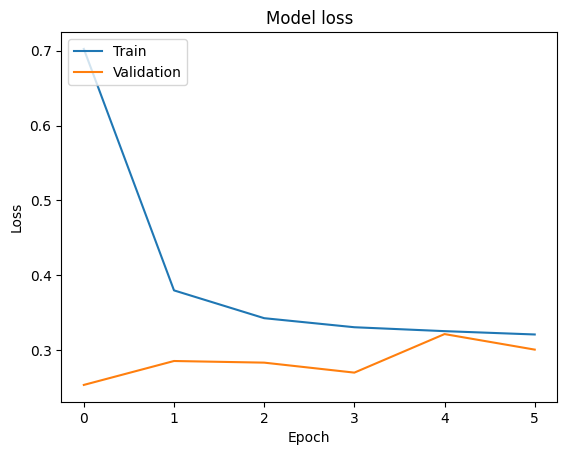

In [121]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fitting to the training set
history = regressor.fit(X_ts_train, Y_ts_train, epochs=50, batch_size=50, callbacks=[early_stopping], validation_data=(X_ts_test, Y_ts_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

In [122]:
data.tail(1)

temp_C  hour  day
543035   14.73     0  334

In [123]:
predict_data = {
    'Dia': [335] * 23,
    'Hora': list(range(1,24))
}
predict_data_df = pd.DataFrame(predict_data)
predict_data_df

Dia  Hora
0   335     1
1   335     2
2   335     3
3   335     4
4   335     5
5   335     6
6   335     7
7   335     8
8   335     9
9   335    10
10  335    11
11  335    12
12  335    13
13  335    14
14  335    15
15  335    16
16  335    17
17  335    18
18  335    19
19  335    20
20  335    21
21  335    22
22  335    23

In [124]:
pred_ts = regressor.predict(scaler_X.transform(predict_data_df.values.astype('float32')))
pred_ts_inv = scaler_Y.inverse_transform(pred_ts)
pred_ts = regressor.predict(X_ts_test)
pred_ts_inv = scaler_Y.inverse_transform(pred_ts)

282/282 [==============================] - 0s 1ms/step


In [125]:
Y_ts_inv = scaler_Y.inverse_transform(Y_ts_test)

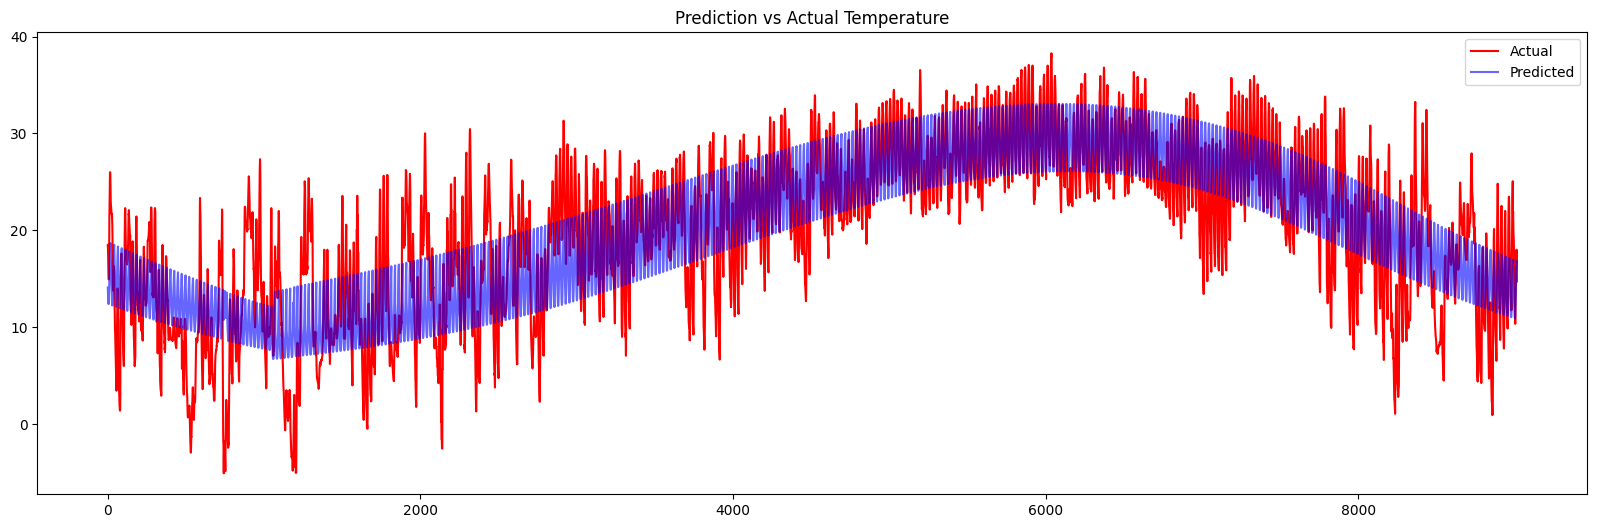

In [126]:
# Actual data
plt.figure(figsize=(20,6))
plt.title("Prediction vs Actual Temperature")
plt.plot(Y_ts_inv, color="red", label="Actual")
plt.plot(pred_ts_inv, color="blue", label="Predicted", alpha=0.6)
plt.legend()
plt.show()

In [71]:
from prophet import Prophet

In [79]:
data_prophet = df[["datetime", "temp_C"]]
data_prophet.rename(columns={"datetime":"ds", "temp_C":"y"}, inplace=True)
data_prophet

/tmp/ipykernel_113753/862579457.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ds          y
497783 2012-10-01 12:00:00  16.590000
497784 2012-10-01 13:00:00  16.590000
497785 2012-10-01 14:00:00  16.612974
497786 2012-10-01 15:00:00  16.680767
497787 2012-10-01 16:00:00  16.748560
...                    ...        ...
543031 2017-11-29 20:00:00  17.330000
543032 2017-11-29 21:00:00  17.870000
543033 2017-11-29 22:00:00  18.000000
543034 2017-11-29 23:00:00  16.440000
543035 2017-11-30 00:00:00  14.730000

[45077 rows x 2 columns]

In [139]:
model = Prophet(weekly_seasonality=False, interval_width=0.95)
model.add_seasonality(name='daily', period=1, fourier_order=2)
model.fit(data_prophet)

10:56:08 - cmdstanpy - INFO - Chain [1] start processing
10:56:21 - cmdstanpy - INFO - Chain [1] done processing


In [153]:
dias = 7

In [154]:
future = model.make_future_dataframe(periods=24*dias, freq="h")
future

ds
0     2012-10-01 12:00:00
1     2012-10-01 13:00:00
2     2012-10-01 14:00:00
3     2012-10-01 15:00:00
4     2012-10-01 16:00:00
...                   ...
45240 2017-12-06 20:00:00
45241 2017-12-06 21:00:00
45242 2017-12-06 22:00:00
45243 2017-12-06 23:00:00
45244 2017-12-07 00:00:00

[45245 rows x 1 columns]

In [155]:
forecast = model.predict(future)

In [156]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2012-10-01 12:00:00  19.233844   10.182859   28.656181    19.233844   
1     2012-10-01 13:00:00  19.234467   10.998946   27.505908    19.234467   
2     2012-10-01 14:00:00  19.235091   11.486550   29.538644    19.235091   
3     2012-10-01 15:00:00  19.235714   11.915509   30.041833    19.235714   
4     2012-10-01 16:00:00  19.236338   14.103842   31.591168    19.236338   
...                   ...        ...         ...         ...          ...   
45240 2017-12-06 20:00:00  19.456922    7.728282   24.875892    19.428619   
45241 2017-12-06 21:00:00  19.456759    7.019289   24.547673    19.427860   
45242 2017-12-06 22:00:00  19.456596    6.808053   24.908901    19.427101   
45243 2017-12-06 23:00:00  19.456433    6.518014   24.797503    19.426342   
45244 2017-12-07 00:00:00  19.456270    6.098947   24.146485    19.425583   

       trend_upper  additive_terms  additive_terms_lower  \
0        19.233844       -0.203208             -0.203208   
1        19.234467        0.233813              0.233813   
2        19.235091        1.033902              1.033902   
3        19.235714        2.158874              2.158874   
4        19.236338        3.506685              3.506685   
...            ...             ...                   ...   
45240    19.472718       -3.307953             -3.307953   
45241    19.472939       -3.118218             -3.118218   
45242    19.473161       -3.376572             -3.376572   
45243    19.473382       -4.005735             -4.005735   
45244    19.473474       -4.884091             -4.884091   

       additive_terms_upper     daily  daily_lower  daily_upper    yearly  \
0                 -0.203208 -3.739263    -3.739263    -3.739263  3.536055   
1                  0.233813 -3.292466    -3.292466    -3.292466  3.526279   
2                  1.033902 -2.482607    -2.482607    -2.482607  3.516509   
3                  2.158874 -1.347872    -1.347872    -1.347872  3.506746   
4                  3.506685  0.009695     0.009695     0.009695  3.496990   
...                     ...       ...          ...          ...       ...   
45240             -3.307953  4.461350     4.461350     4.461350 -7.769303   
45241             -3.118218  4.653062     4.653062     4.653062 -7.771279   
45242             -3.376572  4.396698     4.396698     4.396698 -7.773270   
45243             -4.005735  3.769538     3.769538     3.769538 -7.775274   
45244             -4.884091  2.893201     2.893201     2.893201 -7.777292   

       yearly_lower  yearly_upper  multiplicative_terms  \
0          3.536055      3.536055                   0.0   
1          3.526279      3.526279                   0.0   
2          3.516509      3.516509                   0.0   
3          3.506746      3.506746                   0.0   
4          3.496990      3.496990                   0.0   
...             ...           ...                   ...   
45240     -7.769303     -7.769303                   0.0   
45241     -7.771279     -7.771279                   0.0   
45242     -7.773270     -7.773270                   0.0   
45243     -7.775274     -7.775274                   0.0   
45244     -7.777292     -7.777292                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                             0.0                         0.0  19.030636  
1                             0.0                         0.0  19.468280  
2                             0.0                         0.0  20.268993  
3                             0.0                         0.0  21.394588  
4                             0.0                         0.0  22.743022  
...                           ...                         ...        ...  
45240                         0.0                         0.0  16.148969  
45241                         0.0                         0.0  16.338541  
45242                         0.0                         0.0  16.08

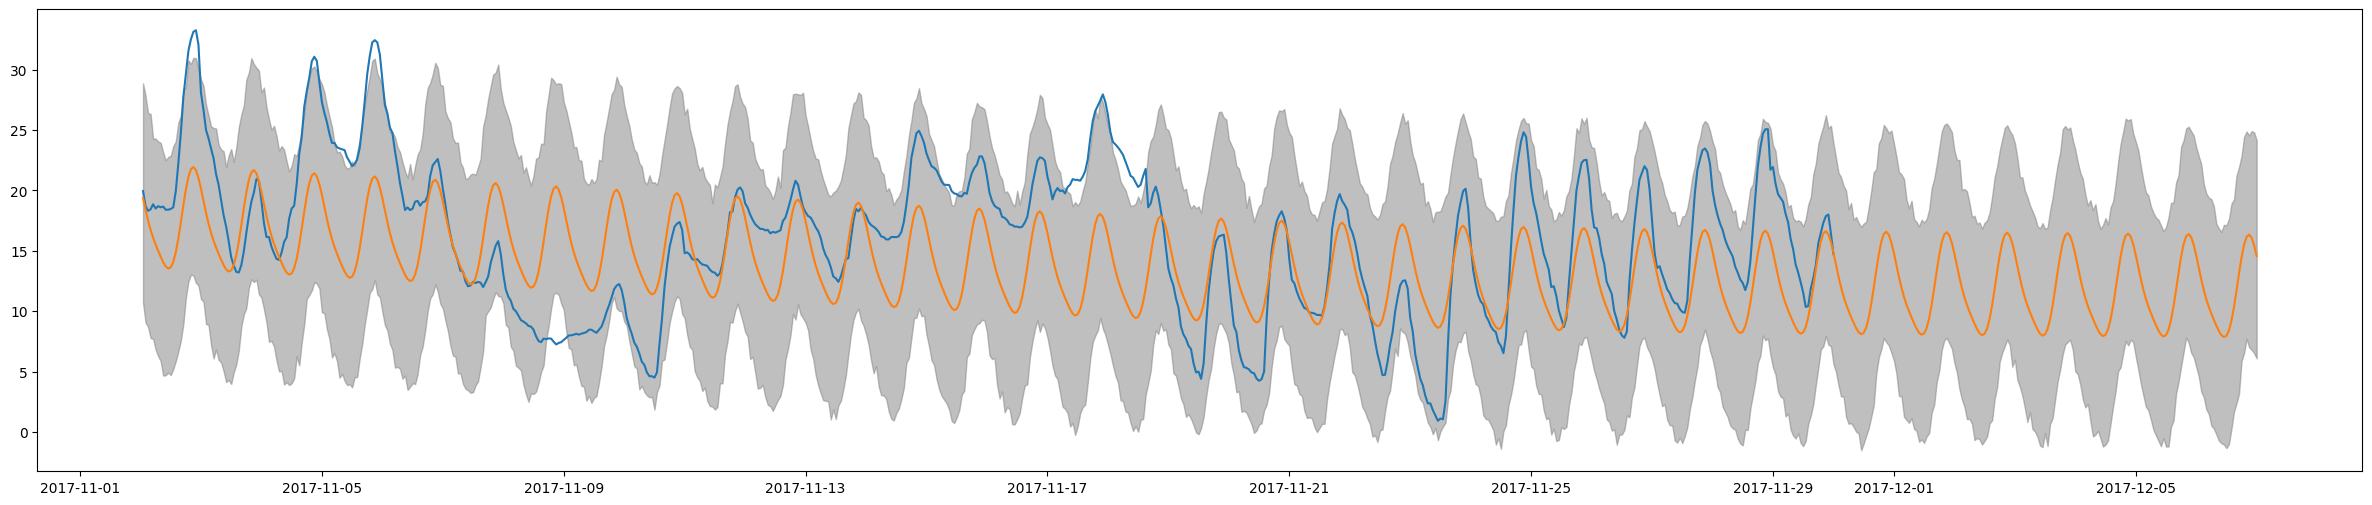

In [163]:
plt.figure(figsize=(30,6))
# Plot the forecast
plt.plot(data_prophet["ds"][-24*7*4:], data_prophet["y"][-24*7*4:])
plt.plot(forecast["ds"][-(24*dias+24*7*4):], forecast["yhat"][-(24*dias+24*7*4):])
plt.fill_between(forecast["ds"][-(24*dias+24*7*4):], forecast["yhat_lower"][-(24*dias+24*7*4):], forecast["yhat_upper"][-(24*dias+24*7*4):], color='gray', alpha=0.5, label='Band between y1 and y2')
plt.show()

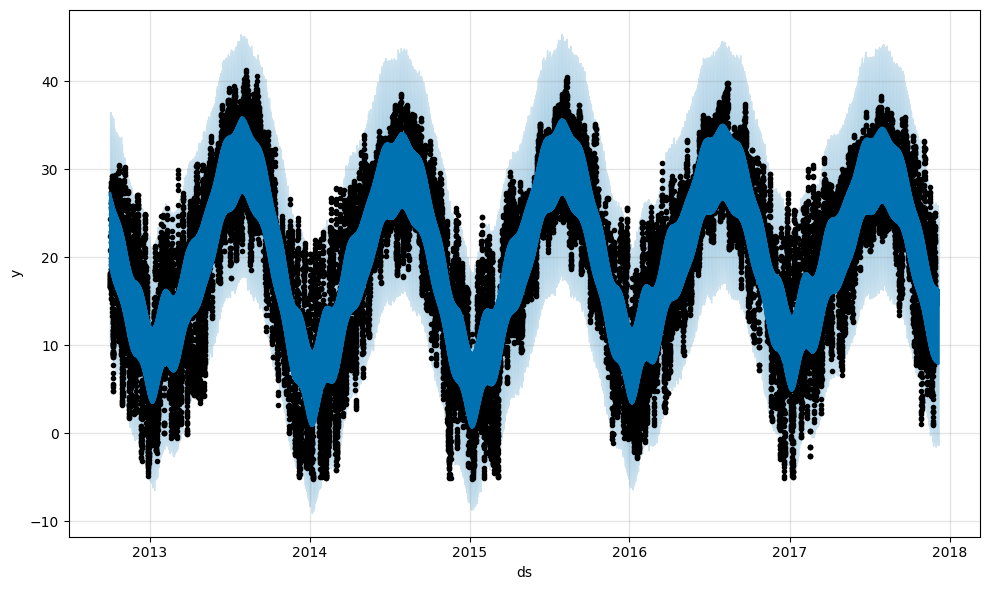

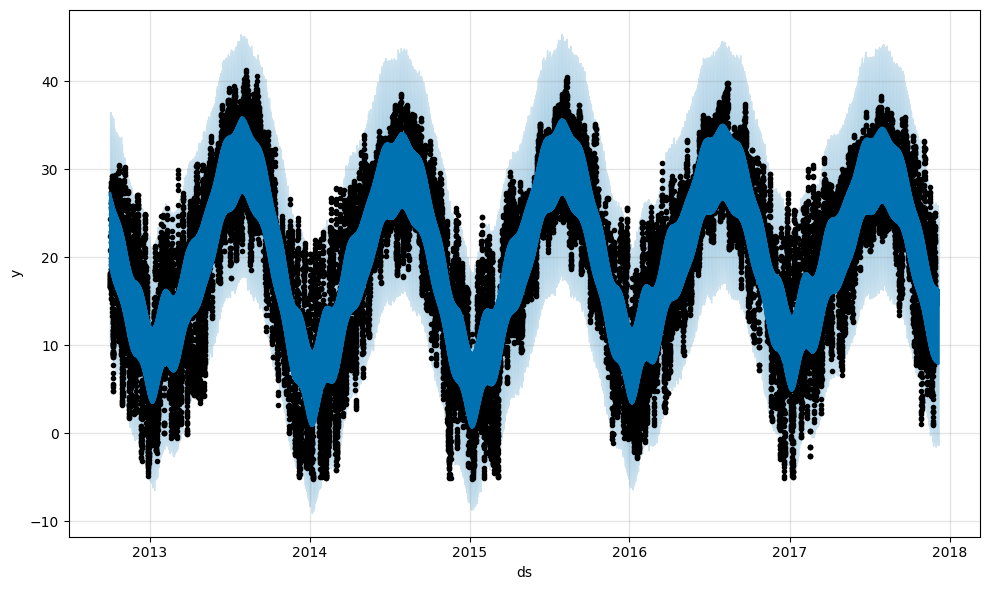

In [162]:
model.plot(forecast)

/home/gorka/.local/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/gorka/.local/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/gorka/.local/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/gorka/.local/lib/python3.10/site-packages/prophet/plot.py:

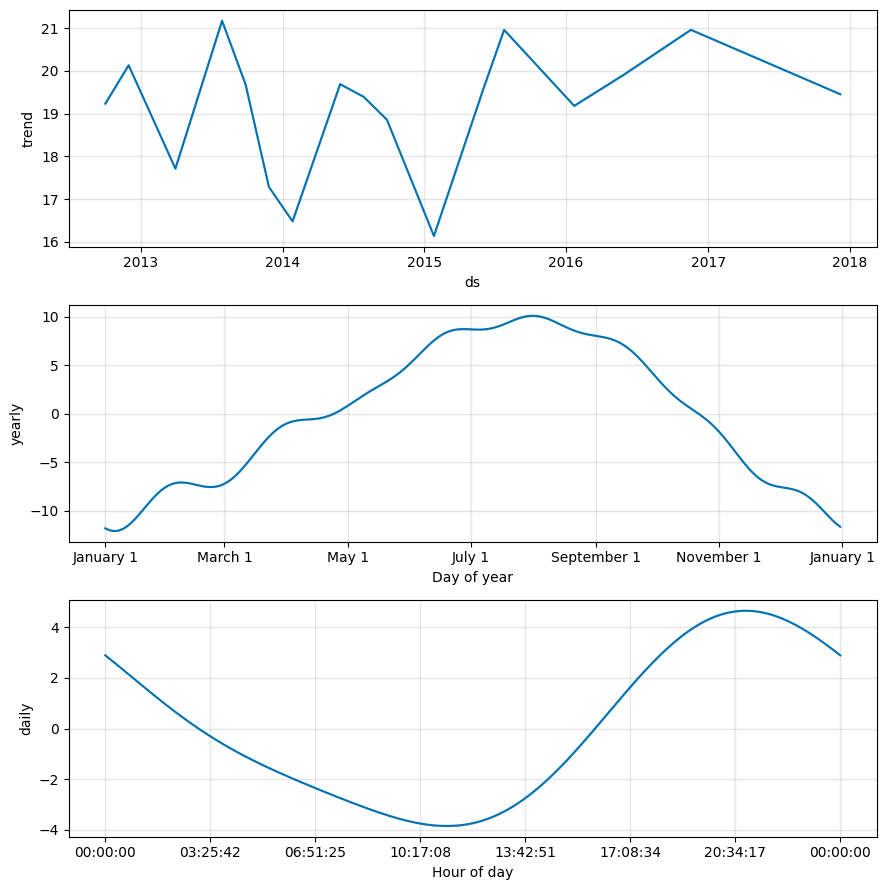

In [164]:

# Optional: Plot the components (trend, weekly seasonality, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

In [90]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)

ds       yhat  yhat_lower  yhat_upper
45077 2017-11-30 01:00:00  14.560534    8.717145   20.503966
45078 2017-11-30 02:00:00  13.663336    7.779694   19.645598
45079 2017-11-30 03:00:00  12.650143    6.697189   18.624964
45080 2017-11-30 04:00:00  11.589875    5.421810   17.277320
45081 2017-11-30 05:00:00  10.554662    4.661614   16.567499
45082 2017-11-30 06:00:00   9.614926    3.457434   15.666188
45083 2017-11-30 07:00:00   8.834585    2.705426   15.231134
45084 2017-11-30 08:00:00   8.266693    2.023322   14.160712
45085 2017-11-30 09:00:00   7.949829    1.559514   13.909992
45086 2017-11-30 10:00:00   7.905463    1.864686   13.788801
45087 2017-11-30 11:00:00   8.136497    2.027234   13.802942
45088 2017-11-30 12:00:00   8.627066    2.734142   14.826896
45089 2017-11-30 13:00:00   9.343617    3.634019   15.515421
45090 2017-11-30 14:00:00  10.237198    4.350910   16.572750
45091 2017-11-30 15:00:00  11.246794    5.513101   17.249083
45092 2017-11-30 16:00:00  12.303485    6.585864   18.339560
45093 2017-11-30 17:00:00  13.335140    7.686425   19.169154
45094 2017-11-30 18:00:00  14.271336    8.465112   20.163634
45095 2017-11-30 19:00:00  15.048157    9.031543   20.839668
45096 2017-11-30 20:00:00  15.612546    9.809347   21.831197
45097 2017-11-30 21:00:00  15.925926   10.006383   21.805124
45098 2017-11-30 22:00:00  15.966825   10.376072   22.048446
45099 2017-11-30 23:00:00  15.732342    9.653684   21.535997
45100 2017-12-01 00:00:00  15.238342    9.153462   21.151345